In [2]:
# pip install PuLP==2.9.0
# pip install matplotlib==3.9.0
from pulp import *
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

import warnings

# Suppress specific UserWarning from pulp
warnings.filterwarnings("ignore", message="Spaces are not permitted in the name. Converted to '_'")

In [3]:
def schedule(employees: list[str], 
             roles: list[str], 
             days: list[str], 
             employee_roles: dict[str, list[str]], 
             role_hours_required: dict[str, dict[str, int]], 
             employee_max_hours: dict[str, dict[str, int]], 
             business_hour_max: int = 12, 
             business_days_max: int = 7):
    
    """
    Schedules employees for different roles on various days while minimizing uncovered hours.
    
    Parameters:
    - employees (list of str): List of employee names.
    - roles (list of str): List of job roles.
    - days (list of str): List of days to schedule.
    - employee_roles (dict of {str: list of str}): Mapping of employee names to their roles.
    - role_hours_required (dict of {str: dict of {str: int}}): Mapping of days to roles to required hours.
    - employee_max_hours (dict of {str: dict of {str: int}}): Mapping of employees to days to their max working hours.
    - business_hour_max (int, optional): Maximum hours any employee can work in a day. Default is 12.
    - business_days_max (int, optional): Maximum days an employee can work in a week. Default is 7.
    
    Returns:
    - schedule_results (dict of {str: dict of {str: dict of {str: int}}}): Scheduled hours for each employee, day, and role.
    - uncovered_results (dict of {str: dict of {str: int}}): Uncovered hours for each day and role.
    - total_uncovered (int): Total number of uncovered hours.
    """

    # Initialize the model
    schedule_problem = LpProblem("Restaurant Employee Scheduling", LpMinimize)

    # Create decision variables for max hours "business_hour_max" worked by each employee in each role on each day
    x = LpVariable.dicts("work", 
                         ((e, r, d) for e in employees for r in roles for d in days), 
                         lowBound=0, upBound=business_hour_max, cat='Integer')  

    # Binary variable to indicate if an employee works in a role on a given day
    y = LpVariable.dicts("working_day", 
                         ((e, r, d) for e in employees for r in roles for d in days), 
                         cat='Binary')

    # Create variables for uncovered hours for each role
    uncovered_hours = LpVariable.dicts("uncovered", 
                                       ((r, d) for r in roles for d in days), 
                                       lowBound=0, cat='Integer')

    # Objective function: Minimize the total number of uncovered role hours
    schedule_problem += lpSum([uncovered_hours[r, d] for r in roles for d in days])

    # Constraints
    for d in days:
        for r in roles:
            # Ensure the required role hours are covered or accounted as uncovered
            schedule_problem += lpSum([x[e, r, d] for e in employees if r in employee_roles[e]]) \
                  + uncovered_hours[r, d] == role_hours_required[d][r]  # Use == instead of >=

            # Ensure the total hours assigned do not exceed role_hours_required
            schedule_problem += lpSum([x[e, r, d] for e in employees if r in employee_roles[e]]) <= role_hours_required[d][r]

    for e in employees:
        for d in days:
            # Use the daily maximum hours for each employee
            max_hours = employee_max_hours[e][d]

            # Ensure each employee works at most their maximum hours per day across all roles
            schedule_problem += lpSum([x[e, r, d] for r in roles]) <= max_hours

            for r in roles:
                # Link binary variable with hours worked (if working, y = 1; otherwise, y = 0)
                schedule_problem += x[e, r, d] <= y[e, r, d] * max_hours

        # Ensure each employee works at most "business_days_max" days per week
        schedule_problem += lpSum([y[e, r, d] for r in roles for d in days]) <= business_days_max

    # Solve the model with verbose output turned off
    schedule_problem.solve(PULP_CBC_CMD(msg=False))

    # Prepare results
    schedule_results = {}
    uncovered_results = {}
    total_uncovered = 0

    for e in employees:
        schedule_results[e] = {}
        for d in days:
            schedule_results[e][d] = {}
            for r in roles:
                hours = x[e, r, d].value()
                if hours > 0:
                    schedule_results[e][d][r] = hours

    for d in days:
        uncovered_results[d] = {}
        for r in roles:
            uncovered = uncovered_hours[r, d].value()
            uncovered_results[d][r] = uncovered
            total_uncovered += uncovered

    return schedule_results, uncovered_results, total_uncovered

In [4]:
def assign_working_hours(schedule_results, opening_hours, coverage_preference="start"):
    """
    Assigns working hours to employees based on the schedule results and business opening hours.
    
    Parameters:
    - schedule_results: dict
        The schedule results with hours each employee will work each day for each role.
    - opening_hours: dict
        The opening hours for each day.
    - coverage_preference: str, optional
        The preference for covering hours: "start", "middle", "end". Default is "start".
    
    Returns:
    - working_hours: dict
        Dictionary with employees' working hours assigned based on opening hours and coverage preference.
    """
    def format_time(time):
        return time.strftime('%H:%M')

    def calculate_working_hours(start_time, hours, preference):
        end_time = start_time + timedelta(hours=hours)
        return format_time(start_time), format_time(end_time)

    working_hours = {}

    for e in schedule_results:
        working_hours[e] = {}
        for d in schedule_results[e]:
            if d not in working_hours[e]:
                working_hours[e][d] = {}

            start_time = datetime.strptime(opening_hours[d]['Start'], '%H:%M')
            end_time = datetime.strptime(opening_hours[d]['End'], '%H:%M')
            business_duration = (end_time - start_time).total_seconds() / 3600

            for r in schedule_results[e][d]:
                hours = schedule_results[e][d][r]
                if hours <= 0:
                    continue

                if coverage_preference == "start":
                    start, end = calculate_working_hours(start_time, hours, "start")
                elif coverage_preference == "end":
                    start, end = calculate_working_hours(end_time - timedelta(hours=hours), hours, "end")
                elif coverage_preference == "middle":
                    middle_start = start_time + timedelta(hours=(business_duration - hours) / 2)
                    start, end = calculate_working_hours(middle_start, hours, "middle")
                else:
                    raise ValueError("Invalid coverage preference. Choose from 'start', 'middle', 'end'.")

                working_hours[e][d][r] = {
                    "Start": start,
                    "End": end
                }

    return working_hours

In [5]:
# Example usage:
employees = ['Alice', 'Mark', 'Bob', 'Susan', 'Charlie']
roles = ['Cook', 'Receptionist', 'Waiter', 'Chef']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

employee_roles = {
    'Alice': ['Cook'],
    'Mark': ['Receptionist'],
    'Bob': ['Waiter'],
    'Susan': ['Chef'],
    'Charlie': ['Waiter']
}

role_hours_required = {
    'Mon': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Tue': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Wed': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Thu': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Fri': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Sat': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12},
    'Sun': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12, 'Chef': 12}
}

employee_max_hours = {
    'Alice': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Mark': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Bob': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Susan': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
    'Charlie': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0, 'Sun': 0},
}

time_off = {'Mon': {'Start': '08:00', 'End': '20:00'}}

location = ()

shift = ['morning', '']

In [6]:
# Call the function with the parameters
schedule_results, uncovered_results, total_uncovered = schedule(
    employees, roles, days, employee_roles, role_hours_required, employee_max_hours
)

In [7]:
# Print the schedule results
print("\nSchedule Results:")
for e in schedule_results:
    print(f"\nSchedule for {e}:")
    for d in schedule_results[e]:
        for r in schedule_results[e][d]:
            hours = schedule_results[e][d][r]
            print(f"  {d} - {r}: {hours} hours")


Schedule Results:

Schedule for Alice:
  Mon - Cook: 8.0 hours
  Tue - Cook: 8.0 hours
  Wed - Cook: 8.0 hours
  Thu - Cook: 8.0 hours
  Fri - Cook: 8.0 hours

Schedule for Mark:
  Mon - Receptionist: 8.0 hours
  Tue - Receptionist: 8.0 hours
  Wed - Receptionist: 8.0 hours
  Thu - Receptionist: 8.0 hours
  Fri - Receptionist: 8.0 hours

Schedule for Bob:
  Mon - Waiter: 4.0 hours
  Tue - Waiter: 4.0 hours
  Wed - Waiter: 4.0 hours
  Thu - Waiter: 4.0 hours
  Fri - Waiter: 4.0 hours

Schedule for Susan:
  Mon - Chef: 8.0 hours
  Tue - Chef: 8.0 hours
  Wed - Chef: 8.0 hours
  Thu - Chef: 8.0 hours
  Fri - Chef: 8.0 hours

Schedule for Charlie:
  Mon - Waiter: 8.0 hours
  Tue - Waiter: 8.0 hours
  Wed - Waiter: 8.0 hours
  Thu - Waiter: 8.0 hours
  Fri - Waiter: 8.0 hours


In [8]:
opening_hours = {
    'Mon': {'Start': '08:00', 'End': '20:00'},
    'Tue': {'Start': '08:00', 'End': '20:00'},
    'Wed': {'Start': '08:00', 'End': '20:00'},
    'Thu': {'Start': '08:00', 'End': '20:00'},
    'Fri': {'Start': '08:00', 'End': '20:00'},
    'Sat': {'Start': '08:00', 'End': '20:00'},
    'Sun': {'Start': '08:00', 'End': '20:00'}
}

assign_working_hours(schedule_results, opening_hours, coverage_preference='end')

{'Alice': {'Mon': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Tue': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Wed': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Thu': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Fri': {'Cook': {'Start': '12:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Mark': {'Mon': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Tue': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Wed': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Thu': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Fri': {'Receptionist': {'Start': '12:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Bob': {'Mon': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Tue': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Wed': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Thu': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Fri': {'Waiter': {'Start': '16:00', 'End': '20:00'}},
  'Sat': {},
  'Sun': {}},
 'Susan': {'Mon': {'

In [9]:
# Print the uncovered hours
print("\nUncovered Hours:")
for d in uncovered_results:
    print(f"\nDay: {d}")
    for r in uncovered_results[d]:
        uncovered = uncovered_results[d][r]
        print(f"  {r}: {uncovered} hours uncovered")

print(f"\nTotal uncovered hours: {total_uncovered}")


Uncovered Hours:

Day: Mon
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Tue
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Wed
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Thu
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Fri
  Cook: 4.0 hours uncovered
  Receptionist: 4.0 hours uncovered
  Waiter: 0.0 hours uncovered
  Chef: 4.0 hours uncovered

Day: Sat
  Cook: 12.0 hours uncovered
  Receptionist: 12.0 hours uncovered
  Waiter: 12.0 hours uncovered
  Chef: 12.0 hours uncovered

Day: Sun
  Cook: 12.0 hours uncovered
  Receptionist: 12.0 hours uncovered
  Waiter: 12.0 hours uncovered
  Chef: 12.0 hours uncovered

Total uncovered hours: 156.0


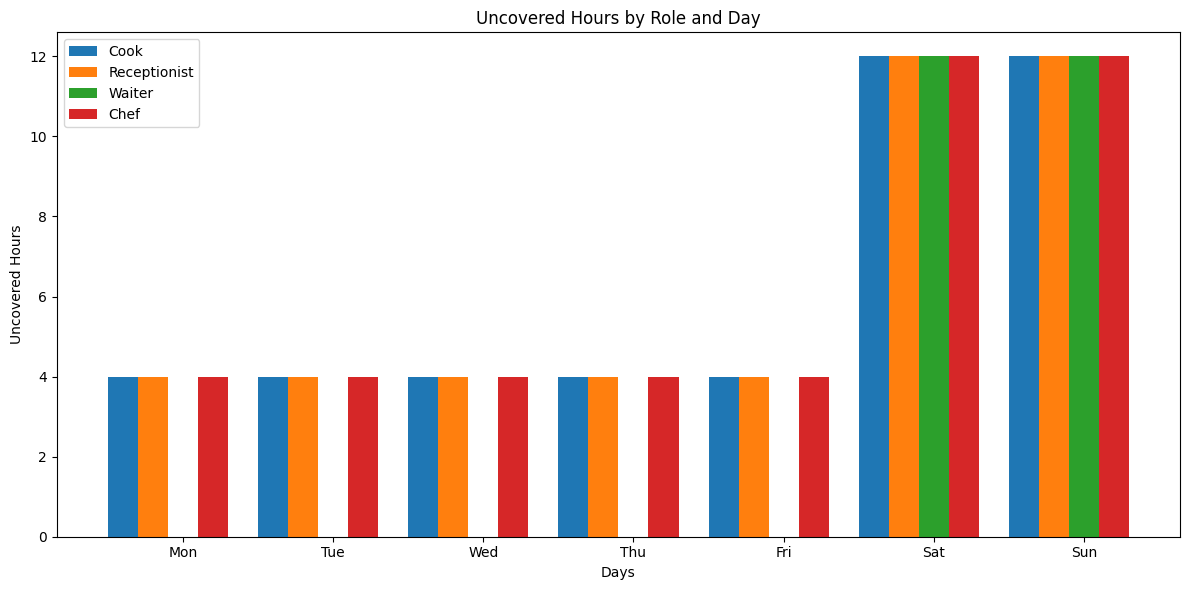

In [10]:
def plot_uncovered_hours(uncovered_results):
    # Prepare data for plotting
    days = list(uncovered_results.keys())
    roles = list(next(iter(uncovered_results.values())).keys())
    
    uncovered_data = {r: [uncovered_results[d][r] for d in days] for r in roles}
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define bar width and positions
    bar_width = 0.2
    positions = [i for i in range(len(days))]
    
    # Plot each role's uncovered hours for each day
    for i, role in enumerate(roles):
        # Add bars for each role
        ax.bar([p + i * bar_width for p in positions], uncovered_data[role], bar_width, label=role)

    # Customize the plot
    ax.set_xlabel('Days')
    ax.set_ylabel('Uncovered Hours')
    ax.set_title('Uncovered Hours by Role and Day')
    ax.set_xticks([p + bar_width * (len(roles) / 2) for p in positions])
    ax.set_xticklabels(days)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# Plot the uncovered hours
plot_uncovered_hours(uncovered_results)

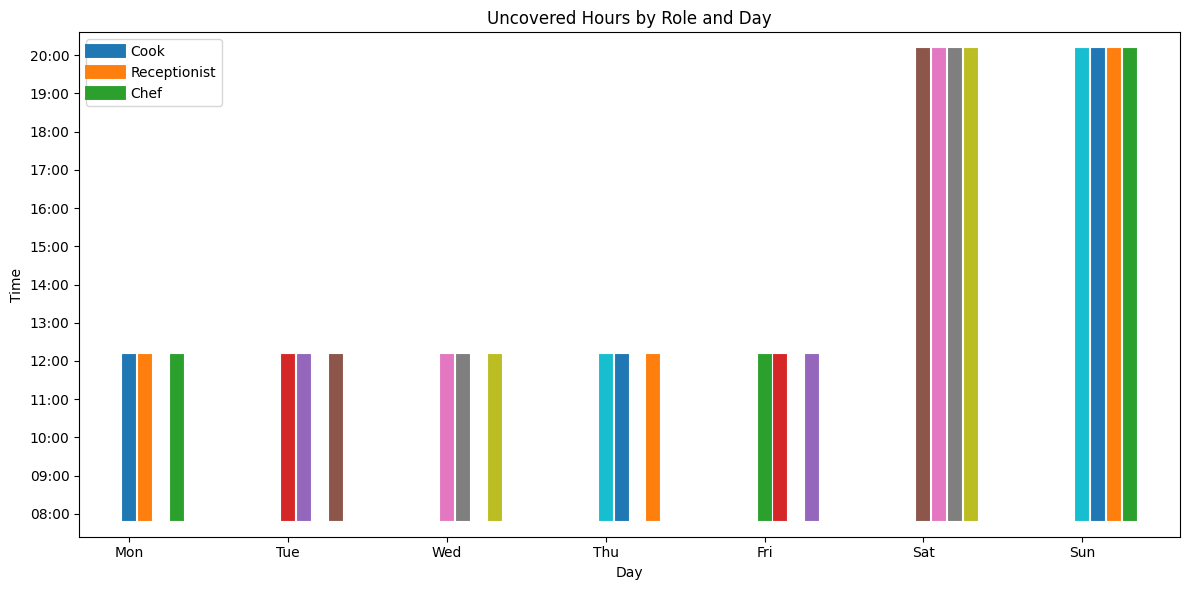

In [11]:
def plot_uncovered_hours_by_time(uncovered_results, opening_hours):
    # Prepare data for plotting
    days = list(uncovered_results.keys())
    roles = list(next(iter(uncovered_results.values())).keys())
    
    # Convert opening hours to datetime objects
    opening_times = {day: {'Start': datetime.strptime(oh['Start'], '%H:%M').time(),
                           'End': datetime.strptime(oh['End'], '%H:%M').time()}
                     for day, oh in opening_hours.items()}
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Loop through days and roles to plot uncovered hours
    for i, day in enumerate(days):
        day_start = datetime.combine(datetime.today(), opening_times[day]['Start'])
        day_end = datetime.combine(datetime.today(), opening_times[day]['End'])
        
        for j, role in enumerate(roles):
            uncovered_hours = uncovered_results[day][role]
            if uncovered_hours > 0:
                start_time = day_start
                end_time = start_time + timedelta(hours=uncovered_hours)
                
                # Adjust the x-position slightly for each role to avoid overlapping
                ax.plot([i + j*0.1, i + j*0.1], [start_time, end_time], label=role if i == 0 else "", linewidth=10)
    
    # Customize the plot
    ax.yaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xticks(range(len(days)))
    ax.set_xticklabels(days)
    ax.set_ylabel('Time')
    ax.set_xlabel('Day')
    ax.set_title('Uncovered Hours by Role and Day')
    
    # Adjust legend to show each role only once
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_uncovered_hours_by_time(uncovered_results, opening_hours)

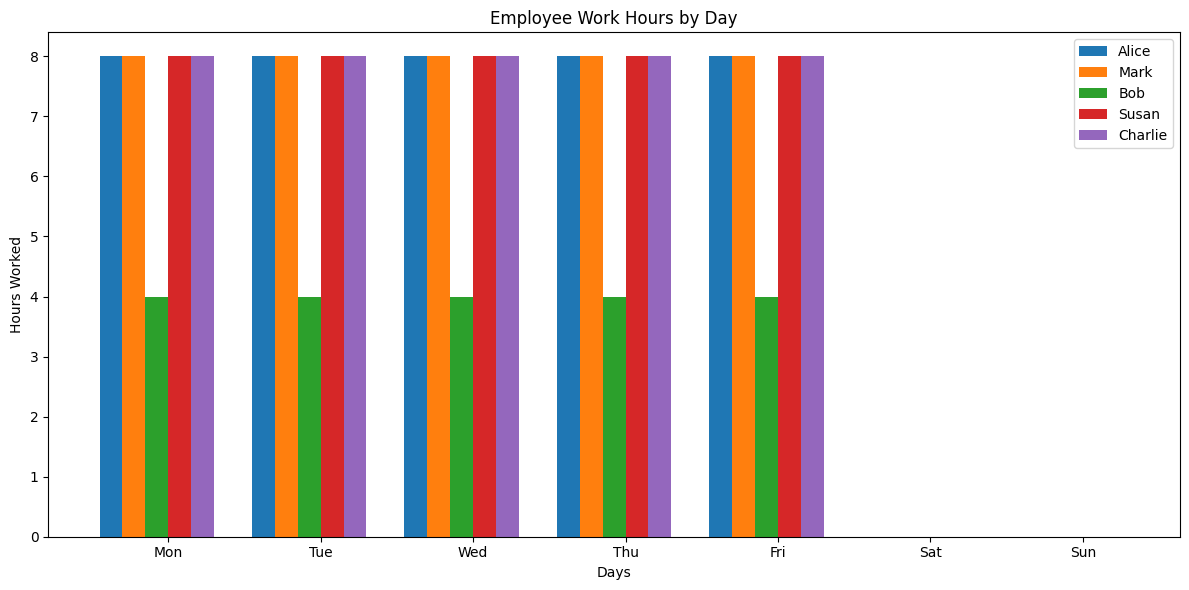

In [12]:
def plot_employee_work_hours(schedule_results):
    # Prepare data for plotting
    days = list(next(iter(schedule_results.values())).keys())
    employees = list(schedule_results.keys())
    
    # Calculate total hours worked by each employee each day
    employee_hours = {e: [sum(schedule_results[e][d].values()) for d in days] for e in employees}

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define bar width and positions
    bar_width = 0.15
    positions = [i for i in range(len(days))]
    
    # Plot each employee's working hours for each day
    for i, employee in enumerate(employees):
        # Add bars for each employee
        ax.bar([p + i * bar_width for p in positions], employee_hours[employee], bar_width, label=employee)

    # Customize the plot
    ax.set_xlabel('Days')
    ax.set_ylabel('Hours Worked')
    ax.set_title('Employee Work Hours by Day')
    ax.set_xticks([p + bar_width * (len(employees) / 2) for p in positions])
    ax.set_xticklabels(days)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the employee work hours
plot_employee_work_hours(schedule_results)